# 03 — Model Training & Evaluation (Sequence, Multi-Output)

This notebook trains and evaluates a multi-output model that predicts the **full next-step state**
(BH mass, accretion, stellar mass, SFR, halo mass, velocity dispersion) from a window of past snapshots.

**Inputs:** `../data/processed/{ids.npy, snapshots.npy, features.npy}` and `../data/stats/{feat_mean.npy, feat_std.npy}`  
**Outputs:** trained checkpoints (`../data/models/`) and forecasts (`../data/forecasts/`).


### 1. Imports & Config
---

In [2]:
from pathlib import Path
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader, random_split

# Reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.default_rng(SEED)

# Paths (must match your data-prep notebook layout)
DATA_ROOT = Path("../data")
PROC_DIR  = DATA_ROOT / "processed"
STATS_DIR = DATA_ROOT / "stats"
MODEL_DIR = DATA_ROOT / "models"
FORE_DIR  = DATA_ROOT / "forecasts"
for d in [PROC_DIR, STATS_DIR, MODEL_DIR, FORE_DIR]:
    d.mkdir(parents=True, exist_ok=True)

# Feature names (order must match your CSV/arrays)
FEATURES = ["bh_mass","bh_acc","stellar_mass","sfr","halo_mass","vel_disp"]

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cpu')

### 2. Load processed arrays & normalization stats (strict)
---

In [3]:
req = {
    "ids":        PROC_DIR / "ids.npy",
    "snapshots":  PROC_DIR / "snapshots.npy",
    "features":   PROC_DIR / "features.npy",
    "feat_mean":  STATS_DIR / "feat_mean.npy",
    "feat_std":   STATS_DIR / "feat_std.npy",
}
missing = [k for k,p in req.items() if not p.exists()]
if missing:
    raise FileNotFoundError(
        f"Missing required files: {missing}. "
        f"Re-run data prep notebook to regenerate arrays/stats."
    )

# Load
ids   = np.load(req["ids"])
snaps = np.load(req["snapshots"]).astype(int)
Xraw  = np.load(req["features"]).astype(np.float32)
mean  = np.load(req["feat_mean"]).astype(np.float64)
std   = np.load(req["feat_std"]).astype(np.float64)

# Basic shape agreement
assert len(ids) == len(snaps) == len(Xraw), "ids/snapshots/features length mismatch"
F = Xraw.shape[1]
assert F == len(FEATURES), f"Feature count {F} != FEATURES list {len(FEATURES)}"

print(f"[OK] Loaded arrays: rows={len(ids)}, features={F}")
print(f"[OK] Snapshot range: {snaps.min()}–{snaps.max()}")


[OK] Loaded arrays: rows=37500, features=6
[OK] Snapshot range: 18–32


### 3. Sanity checks & normalization
---

In [4]:
# NaN / inf checks in raw features
has_nan = np.isnan(Xraw).any()
has_inf = np.isinf(Xraw).any()
print(f"[CHECK] Raw features: NaN={has_nan}, Inf={has_inf}")

# Replace any lingering NaNs/Infs in raw (should be rare after prep)
Xraw = np.nan_to_num(Xraw, nan=0.0, posinf=0.0, neginf=0.0)

# Normalize using stored stats
eps = 1e-8
Xnorm = (Xraw - mean) / (std + eps)
Xnorm = np.nan_to_num(Xnorm, nan=0.0, posinf=0.0, neginf=0.0)

# Quick metadata
n_ids = np.unique(ids).size
by_id_counts = pd.Series(ids).value_counts().describe()[["min","25%","50%","75%","max"]]
print(f"[INFO] Unique subhalos: {n_ids}")
print("[INFO] Sequence length (rows per subhalo) quantiles:\n", by_id_counts.to_string())

# Keep a tiny sample for smoke tests later
ix = np.random.choice(len(ids), size=min(5_000, len(ids)), replace=False)
print(f"[OK] Normalized. Sample slice shape: {Xnorm[ix].shape}")


[CHECK] Raw features: NaN=False, Inf=False
[INFO] Unique subhalos: 2500
[INFO] Sequence length (rows per subhalo) quantiles:
 min    15.0
25%    15.0
50%    15.0
75%    15.0
max    15.0
[OK] Normalized. Sample slice shape: (5000, 6)


### 4. Windowed sequence dataset (W steps → predict next-step full vector)
---

In [5]:
class BHWindowDataset(Dataset):
    """
    Each item:
      X: [W, F]  (window of W normalized steps)
      y: [F]     (next-step full vector, normalized)
    """
    def __init__(self, ids, snaps, feats_norm, window=8):
        self.window = window
        self.samples = []

        # group by subhalo_id and build sliding windows
        for sid in np.unique(ids):
            m = (ids == sid)
            s = snaps[m]
            x = feats_norm[m]
            order = np.argsort(s)
            s = s[order]; x = x[order]

            if len(x) <= window:
                continue
            for t in range(window, len(x)):
                Xw = x[t-window:t, :]   # [W, F]
                y  = x[t, :]            # [F]
                # safety
                if np.isnan(Xw).any() or np.isnan(y).any():
                    continue
                self.samples.append((Xw.astype(np.float32), y.astype(np.float32)))

    def __len__(self): return len(self.samples)

    def __getitem__(self, idx):
        Xw, y = self.samples[idx]
        Xw = torch.from_numpy(Xw)
        y  = torch.from_numpy(y)
        Xw = torch.nan_to_num(Xw, nan=0.0)
        y  = torch.nan_to_num(y,  nan=0.0)
        return Xw, y

# Build dataset and loaders
WINDOW   = 8
BATCH    = 64
VAL_FRAC = 0.2

full_ds = BHWindowDataset(ids, snaps, Xnorm, window=WINDOW)
val_size = int(len(full_ds) * VAL_FRAC)
train_size = len(full_ds) - val_size
train_ds, val_ds = random_split(full_ds, [train_size, val_size], generator=torch.Generator().manual_seed(SEED))

train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True, drop_last=False)
val_loader   = DataLoader(val_ds,   batch_size=BATCH, shuffle=False, drop_last=False)

xb, yb = next(iter(train_loader))
print(f"[OK] Dataset built: {len(full_ds)} samples | Window={WINDOW} | F={xb.shape[-1]}")
print("Batch shapes:", xb.shape, yb.shape)  # (B, W, F) and (B, F)


[OK] Dataset built: 17500 samples | Window=8 | F=6
Batch shapes: torch.Size([64, 8, 6]) torch.Size([64, 6])


### 5. LSTM model (W steps → next-step full vector)
---

In [6]:
import torch
import torch.nn as nn

class BHSequenceLSTM(nn.Module):
    def __init__(self, input_size, hidden=128, layers=2, dropout=0.1, output_size=None):
        super().__init__()
        if output_size is None:
            output_size = input_size
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden,
            num_layers=layers,
            batch_first=True,
            dropout=dropout if layers > 1 else 0.0,
        )
        self.head = nn.Sequential(
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden, output_size),
        )

    def forward(self, x):              # x: [B, W, F]
        h, _ = self.lstm(x)            # h: [B, W, H]
        out = self.head(h[:, -1, :])   # last step → [B, F]
        return out

F = xb.shape[-1]
model = BHSequenceLSTM(input_size=F, hidden=128, layers=2, dropout=0.1, output_size=F).to(device)
print(model)


BHSequenceLSTM(
  (lstm): LSTM(6, 128, num_layers=2, batch_first=True, dropout=0.1)
  (head): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=128, out_features=6, bias=True)
  )
)


### 6. Train (MSE, Adam, grad clipping)
---

In [7]:
import torch.optim as optim
from math import isfinite

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)

EPOCHS = 20
CLIP = 1.0

for ep in range(1, EPOCHS + 1):
    # ---- Train ----
    model.train()
    tr_sum, ntr = 0.0, 0
    for Xw, y in train_loader:
        Xw = torch.nan_to_num(Xw, nan=0.0).to(device)
        y  = torch.nan_to_num(y,  nan=0.0).to(device)

        optimizer.zero_grad()
        pred = model(Xw)
        loss = criterion(pred, y)
        if not isfinite(loss.item()):
            continue
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), CLIP)
        optimizer.step()

        tr_sum += loss.item() * Xw.size(0)
        ntr += Xw.size(0)
    tr = tr_sum / max(ntr, 1)

    # ---- Validate ----
    model.eval()
    va_sum, nva = 0.0, 0
    with torch.no_grad():
        for Xw, y in val_loader:
            Xw = torch.nan_to_num(Xw, nan=0.0).to(device)
            y  = torch.nan_to_num(y,  nan=0.0).to(device)
            v  = criterion(model(Xw), y)
            if isfinite(v.item()):
                va_sum += v.item() * Xw.size(0)
                nva += Xw.size(0)
    va = va_sum / max(nva, 1)

    print(f"Epoch {ep:02d} | train {tr:.6f} | val {va:.6f}")


Epoch 01 | train 1.160895 | val 0.690290
Epoch 02 | train 0.676071 | val 0.569815
Epoch 03 | train 0.577680 | val 0.520194
Epoch 04 | train 0.512043 | val 0.484224
Epoch 05 | train 0.475352 | val 0.464384
Epoch 06 | train 0.448794 | val 0.448995
Epoch 07 | train 0.434585 | val 0.436374
Epoch 08 | train 0.422597 | val 0.424775
Epoch 09 | train 0.413807 | val 0.419059
Epoch 10 | train 0.401216 | val 0.415601
Epoch 11 | train 0.395996 | val 0.407365
Epoch 12 | train 0.386576 | val 0.403734
Epoch 13 | train 0.377140 | val 0.398750
Epoch 14 | train 0.372357 | val 0.396202
Epoch 15 | train 0.368371 | val 0.391614
Epoch 16 | train 0.360466 | val 0.386296
Epoch 17 | train 0.354259 | val 0.386919
Epoch 18 | train 0.348903 | val 0.382090
Epoch 19 | train 0.344277 | val 0.378835
Epoch 20 | train 0.345496 | val 0.378610


### 7. Metrics: per-feature RMSE/MAE (norm + physical units)
---

In [8]:
import numpy as np

def rmse(a, b): return np.sqrt(np.mean((a - b) ** 2, axis=0))
def mae(a, b):  return np.mean(np.abs(a - b), axis=0)

# Collect validation predictions
model.eval()
P_list, T_list = [], []
with torch.no_grad():
    for Xw, y in val_loader:
        Xw = torch.nan_to_num(Xw, nan=0.0).to(device)
        y  = torch.nan_to_num(y,  nan=0.0).to(device)
        P_list.append(model(Xw).cpu().numpy())
        T_list.append(y.cpu().numpy())

P = np.concatenate(P_list, axis=0)   # normalized
T = np.concatenate(T_list, axis=0)

# Norm-space metrics
m_rmse = rmse(P, T)
m_mae  = mae(P, T)
print("Per-feature (normalized) RMSE / MAE:")
for i, name in enumerate(FEATURES):
    print(f"- {name}: RMSE={m_rmse[i]:.4f} | MAE={m_mae[i]:.4f}")

# Physical units (de-normalize)
mean = np.load(STATS_DIR / "feat_mean.npy")
std  = np.load(STATS_DIR / "feat_std.npy")
P_real = P * std + mean
T_real = T * std + mean

m_rmse_r = rmse(P_real, T_real)
m_mae_r  = mae(P_real, T_real)

print("\nPer-feature (physical units) RMSE / MAE:")
for i, name in enumerate(FEATURES):
    print(f"- {name}: RMSE={m_rmse_r[i]:.4e} | MAE={m_mae_r[i]:.4e}")


Per-feature (normalized) RMSE / MAE:
- bh_mass: RMSE=0.3153 | MAE=0.0565
- bh_acc: RMSE=0.8048 | MAE=0.1353
- stellar_mass: RMSE=0.1844 | MAE=0.0549
- sfr: RMSE=1.1604 | MAE=0.1248
- halo_mass: RMSE=0.2804 | MAE=0.0989
- vel_disp: RMSE=0.2555 | MAE=0.1604

Per-feature (physical units) RMSE / MAE:
- bh_mass: RMSE=9.7531e-04 | MAE=1.7476e-04
- bh_acc: RMSE=5.7327e-03 | MAE=9.6397e-04
- stellar_mass: RMSE=1.3329e-01 | MAE=3.9666e-02
- sfr: RMSE=1.2558e+01 | MAE=1.3510e+00
- halo_mass: RMSE=6.9239e+00 | MAE=2.4414e+00
- vel_disp: RMSE=7.2916e+00 | MAE=4.5779e+00


cfg = {
    "model": "BlackHoleNet-v1",
    "lr": 1e-4,
    "batch_size": 64,
    "epochs": 50,
    "optimizer": "Adam",
    "loss_fn": "MSELoss",
}

 Temporary dummy values just to test logging
train_loss = 0.0123
val_loss   = 0.0456
rmse_phys  = [0.1, 0.2, 0.15]  # one per feature in FEATURES
mae_phys   = [0.05, 0.1, 0.08] # one per feature in FEATURES



log_experiment(cfg, train_loss, val_loss, rmse_phys, mae_phys)

### 8. Save checkpoint + simple rollout from a validation window
---

In [9]:
import time
from pathlib import Path

# Ensure dirs exist
MODEL_DIR.mkdir(parents=True, exist_ok=True)
FORE_DIR.mkdir(parents=True, exist_ok=True)

# Save checkpoint (include stats + feature names for portability)
ckpt = {
    "ts": time.strftime("%Y-%m-%d_%H-%M-%S"),
    "state_dict": model.state_dict(),
    "feature_names": FEATURES,
    "mean": mean,
    "std":  std,
    "input_dim": F,
    "window": xb.shape[1],
}
ckpt_path = MODEL_DIR / "blackhole_evolution_lstm.pt"
torch.save(ckpt, ckpt_path)
print(f"[OK] Saved checkpoint → {ckpt_path}")

# ---- Simple K-step rollout from a single val batch ----
def to_norm(x_real):  return (x_real - mean) / (std + 1e-8)
def to_real(x_norm):  return x_norm * std + mean

@torch.no_grad()
def rollout_from_window(model, Xw_real, K=5):
    """
    Xw_real: [W, F] last W steps in real units.
    Returns [K, F] future steps in real units via sliding window autoregression.
    """
    W, F = Xw_real.shape
    # start in normalized space
    Xw = torch.tensor(to_norm(Xw_real), dtype=torch.float32, device=device).unsqueeze(0)  # [1,W,F]
    preds = []
    for _ in range(K):
        y_norm = model(Xw)                      # [1,F]
        y_real = to_real(y_norm.cpu().numpy().squeeze(0))
        # clamp non-physical negatives to zero for nonnegative features
        for j, name in enumerate(FEATURES):
            if y_real[j] < 0:
                y_real[j] = 0.0
        preds.append(y_real.copy())
        # slide window: drop oldest, append new (in norm space)
        y_norm_np = y_norm.cpu().numpy().squeeze(0)
        Xw_np = Xw.cpu().numpy()
        Xw_np = np.concatenate([Xw_np[:, 1:, :], y_norm_np[None, None, :]], axis=1)
        Xw = torch.tensor(Xw_np, dtype=torch.float32, device=device)
    return np.vstack(preds)

# Build one example rollout from a validation sample
# Grab one (Xw_norm, y_norm) pair, convert window back to real units
Xw_norm, _ = next(iter(val_loader))
Xw_norm = Xw_norm[0].numpy()        # [W,F] normalized
Xw_real = Xw_norm * std + mean      # back to physical units

K = 5
future = rollout_from_window(model, Xw_real, K=K)  # [K,F]

# Save forecast CSV
out_df = pd.DataFrame(future, columns=FEATURES)
out_path = FORE_DIR / "forecast_example.csv"
out_df.to_csv(out_path, index=False)
print(f"[OK] Saved {K}-step forecast example → {out_path}")
out_df.head()


[OK] Saved checkpoint → ../data/models/blackhole_evolution_lstm.pt
[OK] Saved 5-step forecast example → ../data/forecasts/forecast_example.csv


,bh_mass,bh_acc,stellar_mass,sfr,halo_mass,vel_disp
0,0.000079,0.0,0.025952,0.426170,5.380926,60.636135
1,0.000081,0.0,0.027456,0.447697,5.519687,61.472343
2,0.000083,0.0,0.029235,0.482392,5.688473,62.356297
3,0.000084,0.0,0.031157,0.525620,5.863894,63.232773
4,0.000085,0.0,0.033193,0.579827,6.059696,64.086121


### 9. Config (single source of truth)
---

CFG = dict(
    WINDOW=8,
    BATCH=64,
    HIDDEN=128,
    LAYERS=2,
    DROPOUT=0.10,
    LR=1e-4,
    WD=1e-4,
    EPOCHS=20,
    CLIP=1.0,
    SEED=42,
)
CFG


### 10. Experiment logger -> ../data/experiments/metrics.csv
---

from pathlib import Path
import csv, time, json

EXP_DIR = Path("../data/experiments")
EXP_DIR.mkdir(parents=True, exist_ok=True)
EXP_CSV = EXP_DIR / "metrics.csv"

def log_experiment(cfg, train_loss, val_loss, rmse_phys, mae_phys):
    row = {
        "ts": time.strftime("%Y-%m-%d_%H-%M-%S"),
        "cfg": json.dumps(cfg),
        "train_loss": float(train_loss),
        "val_loss": float(val_loss),
        # store per-feature metrics as dicts
        "rmse_phys": json.dumps({f: float(x) for f, x in zip(FEATURES, rmse_phys)}),
        "mae_phys":  json.dumps({f: float(x) for f, x in zip(FEATURES, mae_phys)}),
    }
    write_header = not EXP_CSV.exists()
    with open(EXP_CSV, "a", newline="") as f:
        w = csv.DictWriter(f, fieldnames=row.keys())
        if write_header: w.writeheader()
        w.writerow(row)
    print(f"[OK] Logged run → {EXP_CSV}")


### 9. Results directories & small helpers
---

In [24]:
from pathlib import Path
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

RESULTS_DIR = Path("../data/results")
FIG_DIR     = RESULTS_DIR / "figures"
TAB_DIR     = RESULTS_DIR / "tables"
for d in [RESULTS_DIR, FIG_DIR, TAB_DIR]:
    d.mkdir(parents=True, exist_ok=True)

FEATURES = ["bh_mass","bh_acc","stellar_mass","sfr","halo_mass","vel_disp"]

def rmse(a,b,axis=0): return np.sqrt(np.mean((a-b)**2, axis=axis))
def mae(a,b,axis=0):  return np.mean(np.abs(a-b), axis=axis)

print(f"[OK] Results will be saved in {RESULTS_DIR}")


[OK] Results will be saved in ../data/results


### 10. Subhalo-wise splits for windowed dataset (train/val/test)
---

In [25]:
from torch.utils.data import Dataset, DataLoader
import numpy as np

# Reuse arrays/stats from earlier cells
PROC_DIR = Path("../data/processed")
STATS_DIR = Path("../data/stats")
ids   = np.load(PROC_DIR / "ids.npy")
snaps = np.load(PROC_DIR / "snapshots.npy")
Xraw  = np.load(PROC_DIR / "features.npy").astype(np.float32)
mean  = np.load(STATS_DIR / "feat_mean.npy")
std   = np.load(STATS_DIR / "feat_std.npy")
Xnorm = (Xraw - mean) / (std + 1e-8)
Xnorm = np.nan_to_num(Xnorm, nan=0.0, posinf=0.0, neginf=0.0)

WINDOW = 8  # keep consistent with training
SEED   = 42
rng    = np.random.default_rng(SEED)

# Split IDs
unique_ids = np.unique(ids)
rng.shuffle(unique_ids)
n = len(unique_ids)
n_train = int(0.7 * n)
n_val   = int(0.15 * n)
train_ids = set(unique_ids[:n_train])
val_ids   = set(unique_ids[n_train:n_train+n_val])
test_ids  = set(unique_ids[n_train+n_val:])

class BHWindowDataset(Dataset):
    def __init__(self, ids, snaps, feats_norm, window, keep_ids):
        self.samples = []
        for sid in np.unique(ids):
            if sid not in keep_ids:
                continue
            m = (ids == sid)
            s = snaps[m]
            x = feats_norm[m]
            order = np.argsort(s)
            x = x[order]
            if len(x) <= window: 
                continue
            for t in range(window, len(x)):
                Xw = x[t-window:t, :]
                y  = x[t, :]
                if np.isnan(Xw).any() or np.isnan(y).any(): 
                    continue
                self.samples.append((Xw.astype(np.float32), y.astype(np.float32)))

    def __len__(self): return len(self.samples)
    def __getitem__(self, i):
        Xw, y = self.samples[i]
        Xw = torch.from_numpy(Xw)
        y  = torch.from_numpy(y)
        Xw = torch.nan_to_num(Xw, nan=0.0)
        y  = torch.nan_to_num(y,  nan=0.0)
        return Xw, y

# Build splits
train_ds = BHWindowDataset(ids, snaps, Xnorm, WINDOW, train_ids)
val_ds   = BHWindowDataset(ids, snaps, Xnorm, WINDOW, val_ids)
test_ds  = BHWindowDataset(ids, snaps, Xnorm, WINDOW, test_ids)

BATCH = 64
train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=BATCH, shuffle=False)

print(f"[OK] windows | train={len(train_ds)}  val={len(val_ds)}  test={len(test_ds)}")


[OK] windows | train=12250  val=2625  test=2625


### 11. Reload trained model and evaluate on TEST split
---

In [26]:
import torch.nn as nn

MODEL_DIR = Path("../data/models")
CKPT_PATH = MODEL_DIR / "blackhole_evolution_lstm.pt"
ckpt = torch.load(CKPT_PATH, map_location="cpu")
mean = ckpt["mean"]; std = ckpt["std"]

# Rebuild the LSTM architecture exactly as trained
class BHSequenceLSTM(nn.Module):
    def __init__(self, input_size, hidden=128, layers=2, dropout=0.1, output_size=None):
        super().__init__()
        if output_size is None: output_size = input_size
        self.lstm = nn.LSTM(input_size, hidden, num_layers=layers, batch_first=True, dropout=dropout if layers>1 else 0.0)
        self.head = nn.Sequential(nn.Linear(hidden, hidden), nn.ReLU(), nn.Dropout(dropout), nn.Linear(hidden, output_size))
    def forward(self, x):
        h,_ = self.lstm(x)
        return self.head(h[:, -1, :])

F = len(FEATURES)
model = BHSequenceLSTM(input_size=F, hidden=128, layers=2, dropout=0.1, output_size=F).to(device)
model.load_state_dict(ckpt["state_dict"])
model.eval()

# Collect test predictions
P, T = [], []
with torch.no_grad():
    for Xw, y in test_loader:
        Xw = torch.nan_to_num(Xw, nan=0.0).to(device)
        y  = torch.nan_to_num(y,  nan=0.0).to(device)
        P.append(model(Xw).cpu().numpy())
        T.append(y.cpu().numpy())
P = np.concatenate(P, axis=0)   # normalized
T = np.concatenate(T, axis=0)

# Baselines (normalized space)
def baseline_persistence(X_loader):
    preds, target = [], []
    for Xw, y in X_loader:
        preds.append(Xw[:, -1, :].numpy())  # last in window
        target.append(y.numpy())
    return np.concatenate(preds), np.concatenate(target)

P_persist, T_ref = baseline_persistence(test_loader)
assert T_ref.shape == T.shape

# Metrics — normalized
rmse_model_n = rmse(P, T)
mae_model_n  = mae(P, T)
rmse_pers_n  = rmse(P_persist, T)
mae_pers_n   = mae(P_persist, T)

# Metrics — physical units
def denorm(Z): return Z * std + mean
P_r, T_r, Pp_r = denorm(P), denorm(T), denorm(P_persist)
rmse_model = rmse(P_r, T_r); mae_model = mae(P_r, T_r)
rmse_pers  = rmse(Pp_r, T_r); mae_pers = mae(Pp_r, T_r)

# R^2 per feature (physical)
r2 = []
for j in range(F):
    r2.append(r2_score(T_r[:, j], P_r[:, j]))
r2 = np.array(r2)

# Save tables
perfeat = pd.DataFrame({
    "feature": FEATURES,
    "rmse_model": rmse_model,
    "mae_model":  mae_model,
    "r2_model":   r2,
    "rmse_persist": rmse_pers,
    "mae_persist":  mae_pers,
})
perfeat.to_csv(TAB_DIR / "metrics_test_per_feature.csv", index=False)

summary = pd.DataFrame({
    "rmse_model_mean":[rmse_model.mean()],
    "rmse_persist_mean":[rmse_pers.mean()],
    "mae_model_mean":[mae_model.mean()],
    "mae_persist_mean":[mae_pers.mean()],
    "r2_model_mean":[r2.mean()]
})
summary.to_csv(TAB_DIR / "metrics_test_summary.csv", index=False)

print("[OK] Wrote:",
      TAB_DIR / "metrics_test_per_feature.csv",
      "and",
      TAB_DIR / "metrics_test_summary.csv")


[OK] Wrote: ../data/results/tables/metrics_test_per_feature.csv and ../data/results/tables/metrics_test_summary.csv


### 12. Figures (saved to results/figures)
---

[OK] saved ../data/results/figures/rmse_bars_test.png
[OK] saved ../data/results/figures/parity_test.png


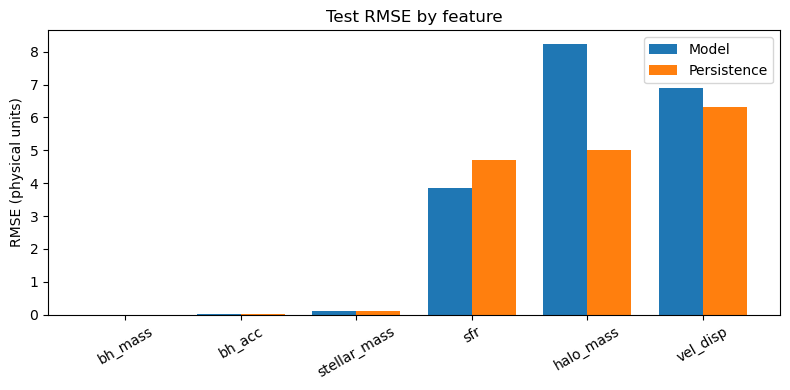

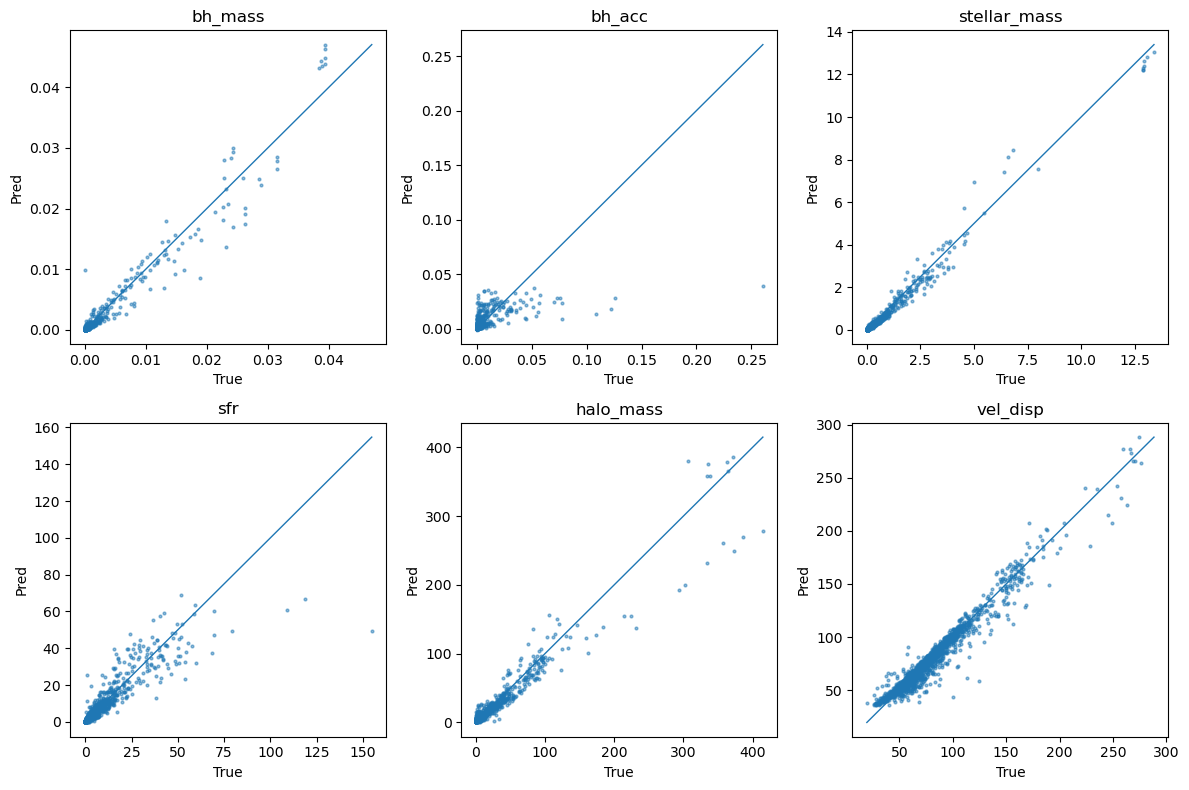

In [27]:
# (A) RMSE bars (model vs persistence) in physical units
x = np.arange(F); width = 0.38
plt.figure(figsize=(8,4))
plt.bar(x - width/2, rmse_model, width, label="Model")
plt.bar(x + width/2, rmse_pers,  width, label="Persistence")
plt.xticks(x, FEATURES, rotation=30)
plt.ylabel("RMSE (physical units)")
plt.title("Test RMSE by feature")
plt.legend()
rmse_bar_path = FIG_DIR / "rmse_bars_test.png"
plt.tight_layout(); plt.savefig(rmse_bar_path, dpi=200)
print(f"[OK] saved {rmse_bar_path}")

# (B) Parity plots (pred vs true) per feature
cols = 3; rows = int(np.ceil(F/cols))
plt.figure(figsize=(12, 8))
for j in range(F):
    ax = plt.subplot(rows, cols, j+1)
    ax.scatter(T_r[:2000, j], P_r[:2000, j], s=4, alpha=0.5)
    mn = min(T_r[:, j].min(), P_r[:, j].min()); mx = max(T_r[:, j].max(), P_r[:, j].max())
    ax.plot([mn, mx], [mn, mx], lw=1)
    ax.set_title(FEATURES[j]); ax.set_xlabel("True"); ax.set_ylabel("Pred")
plt.tight_layout()
parity_path = FIG_DIR / "parity_test.png"
plt.savefig(parity_path, dpi=200)
print(f"[OK] saved {parity_path}")


### 13. K-step rollout error (normalized) on TEST windows
---

In [28]:
K = 5
def rollout_batch_norm(model, Xseq):  # Xseq [B,W,F] normalized
    B, W, F = Xseq.shape
    x = Xseq[:, -1, :]
    out = []
    with torch.no_grad():
        for _ in range(K):
            y = model(torch.from_numpy(x[:, None, :]).float().to(device)).cpu().numpy()
            out.append(y)
            x = y
    return np.stack(out, axis=1)  # [B,K,F]

# collect a block of test windows (normalized) & the immediate next true step
Xv, Yv = [], []
for Xw, y in test_loader:
    Xv.append(Xw.numpy()); Yv.append(y.numpy())
Xv = np.concatenate(Xv); Yv = np.concatenate(Yv)

Pr = rollout_batch_norm(model, Xv)  # [N,K,F]
k1_rmse_n = rmse(Pr[:,0,:], Yv)     # first-step RMSE (norm)
pd.DataFrame({"feature": FEATURES, "rmse_k1_norm": k1_rmse_n}).to_csv(TAB_DIR / "rollout_k1_norm.csv", index=False)
print("[OK] wrote", TAB_DIR / "rollout_k1_norm.csv")


[OK] wrote ../data/results/tables/rollout_k1_norm.csv


### 14. Write a concise results.md with key numbers for the paper
---

In [29]:
sum_df = pd.read_csv(TAB_DIR / "metrics_test_summary.csv")
pf_df  = pd.read_csv(TAB_DIR / "metrics_test_per_feature.csv")

lines = []
lines.append("# Results (Test Set)\n")
lines.append(f"- Mean RMSE (model): {sum_df['rmse_model_mean'][0]:.3e}")
lines.append(f"- Mean RMSE (persistence): {sum_df['rmse_persist_mean'][0]:.3e}")
lines.append(f"- Mean MAE (model): {sum_df['mae_model_mean'][0]:.3e}")
lines.append(f"- Mean R² (model): {sum_df['r2_model_mean'][0]:.3f}\n")

lines.append("## Per-feature metrics\n")
for _, r in pf_df.iterrows():
    lines.append(
        f"- **{r['feature']}**: RMSE={r['rmse_model']:.3e} (persist {r['rmse_persist']:.3e}), "
        f"MAE={r['mae_model']:.3e}, R²={r['r2_model']:.3f}"
    )

lines.append("\n## Figures\n")
lines.append(f"- RMSE bars: `results/figures/{rmse_bar_path.name}`")
lines.append(f"- Parity plots: `results/figures/{parity_path.name}`")

out_md = RESULTS_DIR / "results.md"
out_md.write_text("\n".join(lines))
print(f"[OK] wrote {out_md}")


[OK] wrote ../data/results/results.md
